In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
import phate

In [14]:
# symsim_r1b1 = endoRNA_noIAC(standardize=False)
# symsim_r1b2 = endoATAC_noIAC(standardize=False)
symsim_r1b1 = endoRNA(standardize=False)
symsim_r1b2 = endoATAC(standardize=False)

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 128,
    'layers': [256, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b2_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    _, Diff1 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 20, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 40)

    Diff1 = torch.FloatTensor(Diff1).to(device)
    X_phate1 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())
    


for data in test_r1b2_loader:
    _, Diff2 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 100, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 70)
    

    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    X_phate2 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())

Calculating PHATE...
  Running PHATE on 1628 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.41 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 9.94 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.22 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.40 seconds.
Calculated PHATE in 15.00 seconds.
Calculating PHATE...
  Running PHATE on 1186 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.15 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 se

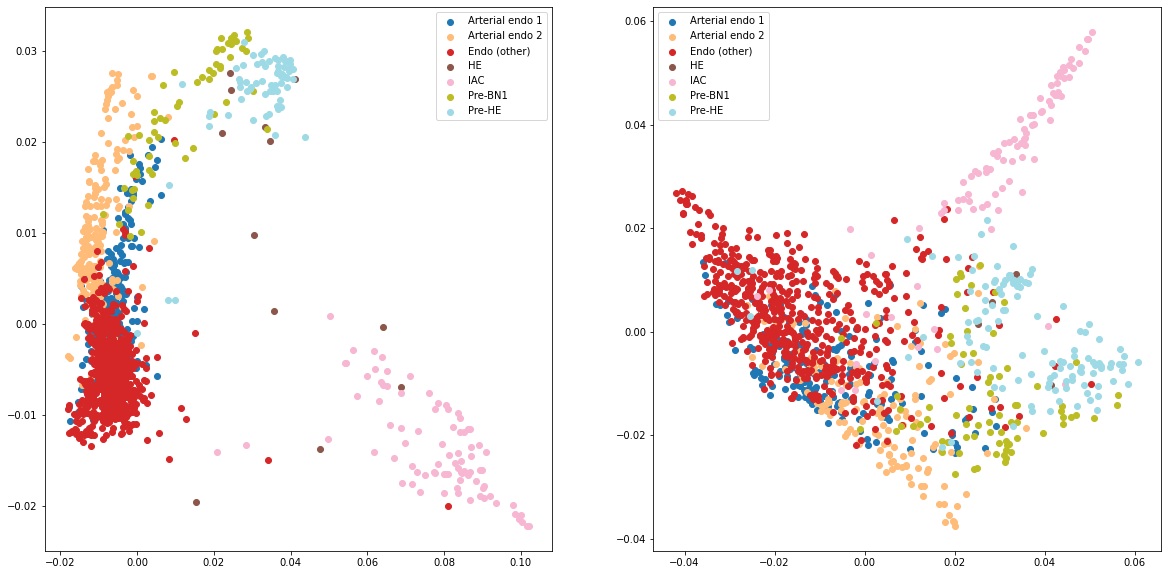

In [22]:
plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [4]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 5e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 5e-4)

In [5]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, n_epochs=151, n_iter=15, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=0)

epoch:  0 RNA loss: 0.22422, RNA recon loss: 0.00000, RNA dist loss: 0.22422 ATAC loss: 0.30032, ATAC recon loss: 0.00000, ATAC dist loss: 0.30032 Discriminator loss: 0.00000
epoch:  10 RNA loss: 0.07000, RNA recon loss: 0.00000, RNA dist loss: 0.07000 ATAC loss: 0.10796, ATAC recon loss: 0.00000, ATAC dist loss: 0.10796 Discriminator loss: 0.00000
epoch:  20 RNA loss: 0.04920, RNA recon loss: 0.00000, RNA dist loss: 0.04920 ATAC loss: 0.07110, ATAC recon loss: 0.00000, ATAC dist loss: 0.07110 Discriminator loss: 0.00000
epoch:  30 RNA loss: 0.04924, RNA recon loss: 0.00000, RNA dist loss: 0.04924 ATAC loss: 0.08458, ATAC recon loss: 0.00000, ATAC dist loss: 0.08458 Discriminator loss: 0.00000
epoch:  40 RNA loss: 0.04588, RNA recon loss: 0.00000, RNA dist loss: 0.04588 ATAC loss: 0.05722, ATAC recon loss: 0.00000, ATAC dist loss: 0.05722 Discriminator loss: 0.00000
epoch:  50 RNA loss: 0.06938, RNA recon loss: 0.00000, RNA dist loss: 0.06938 ATAC loss: 0.06239, ATAC recon loss: 0.0000

In [6]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config1': symsim_r1b1_CONFIG,
#     'config2': symsim_r1b2_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/endo_phate_new_withIAC3.pt')

In [7]:
# state = torch.load('./saved_model/endo_phate_test.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)
# disc.load_state_dict(state['disc'])

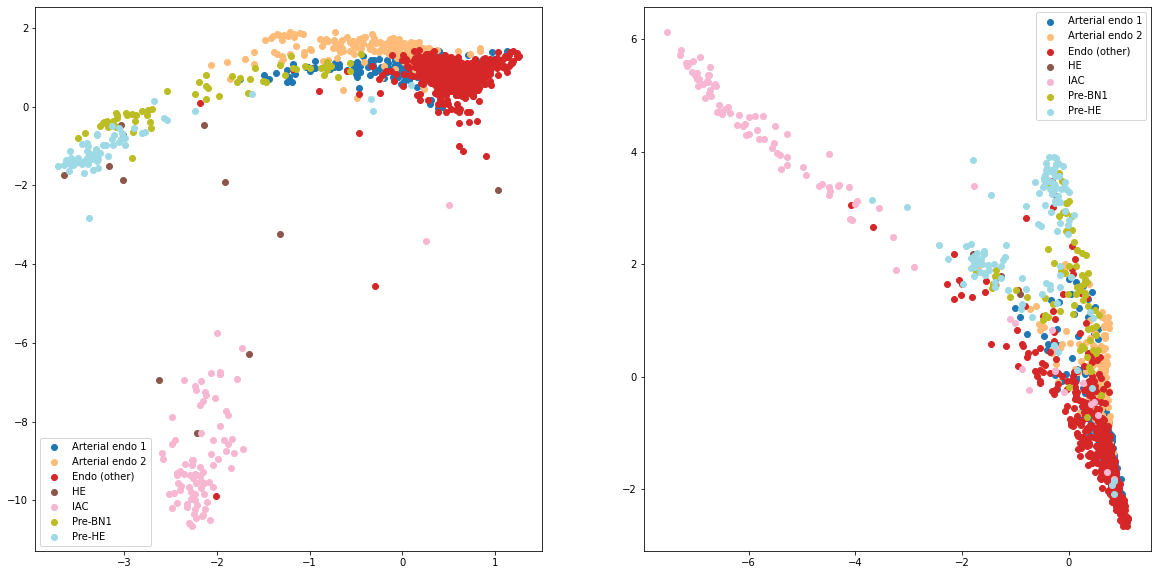

In [20]:
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "joint",save = "./result/endo/new/with_IAC/joint2.pdf")

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = "./result/test_distance/endo_large_t_mse.pdf")

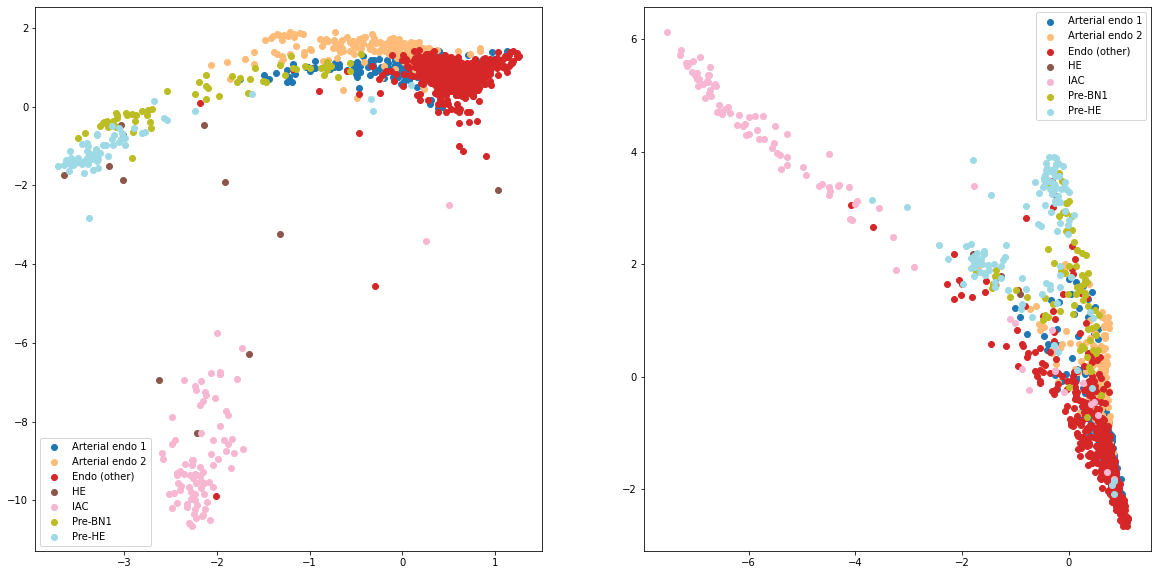

In [9]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

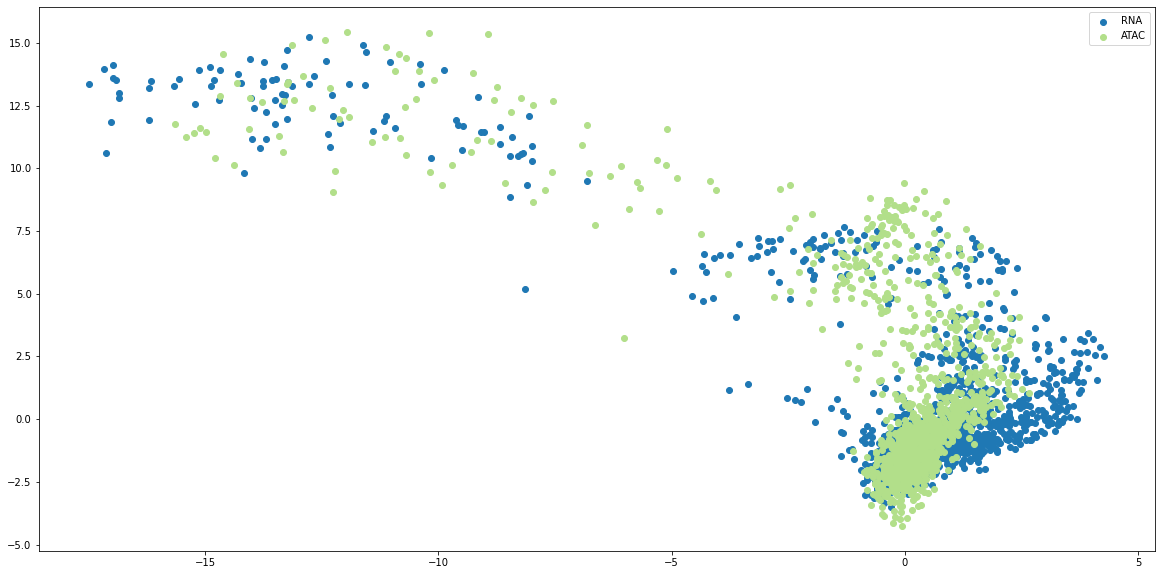

In [57]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = 'result/endo/new/with_IAC/modality3.pdf')